<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/bert_movies_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(9)

import tensorflow as tf
from tensorflow import set_random_seed
import tensorflow_hub as hub
set_random_seed(9)

import tensorflow.keras
from tensorflow.keras import backend as K
from tqdm import tqdm_notebook
import re 

print(tf.__version__)

1.12.0


In [0]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.8MB/s 


In [0]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 3.4MB/s 


In [0]:
!nvidia-smi

Sat Jul  6 09:23:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import glob

path = r'gdrive/My Drive/TFG/movies/' # use your path
all_files = glob.glob(path + "/*.csv")
print(len(all_files))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep='|')
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

59


In [0]:
data = data.sort_values('id').reset_index(drop=True)

In [0]:
data = data.dropna(subset=['overview']).reset_index(drop=True)

In [0]:
len(data)

56881

In [0]:
data = data[~data['overview'].str.contains('Recuerda que puedes ver esta película')]
data = data[data.overview.str.split().apply(len)>10].reset_index(drop=True)

In [0]:
data['overview'].str.split().apply(len).describe().astype(int)

count    55758
mean        63
std         33
min         11
25%         38
50%         58
75%         83
max        191
Name: overview, dtype: int64

In [0]:
df = data[['overview','genres']]

In [0]:
def eval_cell(cell):
  
  try:
    
    cell_array = eval(cell)
  
  except:
    
    cell_array = []
  
  return cell_array

def get_genres(cell):
  
  cell_array = eval_cell(cell)

  if len(cell_array)>0:
    #ids_list = [v['name'] for v in cell_array]
    ids_list = sorted([v['name'] for v in cell_array])
    
  else:
    ids_list = []
  
  return ids_list

from sklearn.preprocessing import MultiLabelBinarizer

# Crate Dataframe with ids
def create_df_genres(ids,column_name):
  
  enc = MultiLabelBinarizer()
  np_ids = enc.fit_transform(ids)
  
  # Save encoder in a pickle
  
  column_names = []
  print('Num of '+ column_name + ': ' + str(len(enc.classes_)))
  
  for c in enc.classes_:
    column_names.append(str(c))
  
  df_ids = pd.DataFrame(data = np_ids, index=data.index, columns=column_names)
  
  return df_ids


# Merge dataframe ids with data
def merge_ids(data,column_name):

  ids = data[column_name].apply(lambda x: get_genres(x))
    
  df_ids = create_df_genres(ids,column_name)
  
  df = data.copy()
  df = df.join(df_ids)
  
  return df

In [0]:
df = merge_ids(df,'genres')
df['genres'] = data['genres'].apply(lambda x: get_genres(x)).apply(tuple)

Num of genres: 19


In [0]:
df = df.drop(['Película de TV'],axis=1)

In [0]:
sum_genres = df.iloc[:,-18:].sum(axis=0).astype(int).sort_values().to_dict()
print(sum_genres)

{'Bélica': 1481, 'Western': 1554, 'Historia': 1676, 'Música': 1848, 'Fantasía': 2845, 'Misterio': 2962, 'Animación': 3306, 'Familia': 3394, 'Ciencia ficción': 3589, 'Documental': 3637, 'Aventura': 4630, 'Crimen': 4762, 'Terror': 5920, 'Romance': 6870, 'Acción': 7559, 'Suspense': 8882, 'Comedia': 13677, 'Drama': 22551}


In [0]:
df['n_genres'] = df.iloc[:,-18:].sum(axis=1)
df = df[df['n_genres'] != 0].reset_index(drop=True)
df = df.iloc[:,:-1]

In [0]:
vc = df['genres'].value_counts()
vc.describe().astype(int)

count    1925
mean       26
std       205
min         1
25%         1
50%         2
75%         7
max      6443
Name: genres, dtype: int64

In [0]:
df.shape

(50061, 20)

In [0]:
vc

(Drama,)                                                           6443
(Comedia,)                                                         3939
(Documental,)                                                      2805
(Drama, Romance)                                                   1794
(Comedia, Drama)                                                   1716
(Terror,)                                                          1426
(Comedia, Romance)                                                 1119
(Comedia, Drama, Romance)                                          1005
(Drama, Suspense)                                                   842
(Suspense, Terror)                                                  821
(Suspense,)                                                         700
(Crimen, Drama)                                                     660
(Western,)                                                          638
(Animación,)                                                    

In [0]:
len(vc[vc<3])

1113

In [0]:
from bert.tokenization import FullTokenizer

# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1"
max_seq_length = data['overview'].str.split().apply(len).max()

In [0]:
# Create datasets (Only take up to max_seq_length words for memory)
X = df['overview'].tolist()
X = [' '.join(t.split()[0:max_seq_length]) for t in X]
X = np.array(X, dtype=object)[:, np.newaxis]
y = df.iloc[:,-18:].values

In [0]:
from sklearn.model_selection import train_test_split

train_text, test_text, train_labels_ok, test_labels_ok = train_test_split(X, y, test_size = 0.5, random_state = 1996)

In [0]:
from skmultilearn.model_selection import IterativeStratification

def iterative_train_test_split(X, y, test_size):
    
    stratifier = IterativeStratification(n_splits=2, order=4, sample_distribution_per_fold=[test_size, 1.0-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, y))

    X_train, y_train = X[train_indexes], y[train_indexes, :]
    X_test, y_test = X[test_indexes], y[test_indexes, :]

    return X_train, X_test, y_train, y_test

In [0]:
X_train, X_test, y_train, y_test = iterative_train_test_split(X,y,0.2)

X_test, X_dev, y_test, y_dev = iterative_train_test_split(X_test,y_test,0.5) 

In [0]:
print(len(X_train))
print(len(X_dev))
print(len(X_test))

40061
4995
5005


In [0]:
labels_list = df.columns[-18:]
print(labels_list)

Index(['Acción', 'Animación', 'Aventura', 'Bélica', 'Ciencia ficción',
       'Comedia', 'Crimen', 'Documental', 'Drama', 'Familia', 'Fantasía',
       'Historia', 'Misterio', 'Música', 'Romance', 'Suspense', 'Terror',
       'Western'],
      dtype='object')


In [0]:
def unique_tuple(my_tuple):
  
  return tuple(set(my_tuple))

In [0]:
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix


pd.DataFrame({
    'train': Counter(str(unique_tuple(combination)) for row in get_combination_wise_output_matrix(y_train, order=4) for combination in row),
    'dev': Counter(str(unique_tuple(combination)) for row in get_combination_wise_output_matrix(y_dev, order=4) for combination in row),
    'test' : Counter(str(unique_tuple(combination)) for row in get_combination_wise_output_matrix(y_test, order=4) for combination in row)
}).T.fillna(0.0)

,"(0, 1)","(0, 1, 10)","(0, 1, 10, 12)","(0, 1, 10, 13)","(0, 1, 10, 14)","(0, 1, 10, 15)","(0, 1, 10, 16)","(0, 1, 10, 3)","(0, 1, 10, 4)","(0, 1, 10, 5)","(0, 1, 10, 8)","(0, 1, 10, 9)","(0, 1, 11)","(0, 1, 11, 8)","(0, 1, 12)","(0, 1, 12, 15)","(0, 1, 12, 16)","(0, 1, 12, 5)","(0, 1, 12, 6)","(0, 1, 12, 8)","(0, 1, 12, 9)","(0, 1, 13)","(0, 1, 13, 5)","(0, 1, 14)","(0, 1, 15)","(0, 1, 16)","(0, 1, 16, 15)","(0, 1, 17)","(0, 1, 2)","(0, 1, 2, 10)","(0, 1, 2, 12)","(0, 1, 2, 13)","(0, 1, 2, 14)","(0, 1, 2, 15)","(0, 1, 2, 16)","(0, 1, 2, 3)","(0, 1, 2, 4)","(0, 1, 2, 5)","(0, 1, 2, 6)","(0, 1, 2, 8)",...,"(9, 2, 4, 14)","(9, 2, 4, 15)","(9, 2, 4, 5)","(9, 2, 4, 6)","(9, 2, 5)","(9, 2, 5, 14)","(9, 2, 5, 15)","(9, 2, 5, 17)","(9, 2, 5, 6)","(9, 2, 6)","(9, 2, 6, 15)","(9, 2, 7)","(9, 3)","(9, 3, 4)","(9, 3, 5)","(9, 3, 7)","(9, 4)","(9, 4, 12)","(9, 4, 12, 15)","(9, 4, 13)","(9, 4, 14)","(9, 4, 15)","(9, 4, 5)","(9, 4, 5, 14)","(9, 4, 5, 15)","(9, 4, 5, 6)","(9, 4, 6)","(9, 5)","(9, 5, 14)","(9, 5, 15)","(9, 5, 17)","(9, 5, 6)","(9, 5, 6, 14)","(9, 5, 6, 15)","(9, 6)","(9, 6, 14)","(9, 6, 15)","(9, 6, 7)","(9, 7)","(9,)"
train,1323.0,327.0,7.0,1.0,6.0,7.0,9.0,0.0,30.0,29.0,12.0,17.0,6.0,1.0,60.0,3.0,3.0,3.0,6.0,7.0,3.0,3.0,0.0,27.0,84.0,69.0,2.0,3.0,510.0,54.0,6.0,1.0,5.0,5.0,4.0,2.0,52.0,40.0,6.0,15.0,...,3.0,4.0,46.0,1.0,1026.0,17.0,3.0,3.0,8.0,30.0,2.0,6.0,30.0,3.0,9.0,3.0,603.0,27.0,2.0,3.0,18.0,18.0,282.0,2.0,0.0,1.0,3.0,3510.0,324.0,33.0,30.0,66.0,0.0,2.0,99.0,6.0,18.0,3.0,81.0,2715.0
dev,165.0,42.0,0.0,0.0,2.0,1.0,1.0,0.0,4.0,4.0,3.0,2.0,0.0,0.0,9.0,1.0,1.0,2.0,1.0,1.0,0.0,3.0,1.0,6.0,9.0,15.0,1.0,0.0,63.0,7.0,0.0,1.0,1.0,1.0,1.0,1.0,7.0,5.0,1.0,3.0,...,0.0,1.0,5.0,0.0,129.0,2.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,3.0,0.0,0.0,3.0,3.0,36.0,1.0,1.0,0.0,0.0,438.0,39.0,9.0,3.0,12.0,1.0,1.0,15.0,3.0,6.0,0.0,12.0,339.0
test,165.0,39.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,4.0,1.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,6.0,0.0,0.0,63.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,5.0,0.0,1.0,...,0.0,1.0,6.0,0.0,129.0,2.0,0.0,0.0,1.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,87.0,3.0,0.0,0.0,0.0,3.0,36.0,0.0,0.0,0.0,0.0,438.0,42.0,0.0,3.0,6.0,0.0,0.0,9.0,0.0,0.0,0.0,9.0,340.0


In [0]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(y_train)
print("{} labels, {} edges".format(len(labels_list), len(edge_map)))
print(edge_map)

18 labels, 152 edges
{(5, 6): 672.0, (5, 8): 3191.0, (6, 8): 2158.0, (0, 2): 1647.0, (0, 4): 1074.0, (2, 4): 620.0, (8, 12): 1158.0, (12, 15): 1379.0, (12, 16): 653.0, (15, 16): 1814.0, (0, 10): 549.0, (2, 10): 746.0, (4, 10): 435.0, (0, 15): 2006.0, (2, 15): 486.0, (4, 15): 723.0, (10, 15): 215.0, (3, 8): 866.0, (1, 11): 26.0, (4, 8): 511.0, (4, 14): 144.0, (8, 14): 3574.0, (8, 15): 3057.0, (6, 15): 1774.0, (4, 12): 169.0, (8, 13): 505.0, (6, 12): 708.0, (13, 14): 298.0, (0, 8): 1912.0, (2, 8): 988.0, (0, 11): 205.0, (2, 11): 175.0, (8, 11): 997.0, (0, 5): 1079.0, (0, 6): 1131.0, (2, 5): 852.0, (4, 5): 498.0, (2, 9): 839.0, (4, 9): 201.0, (5, 9): 1170.0, (12, 13): 13.0, (12, 14): 182.0, (5, 14): 2346.0, (1, 2): 671.0, (1, 8): 294.0, (1, 9): 1039.0, (8, 9): 701.0, (1, 10): 502.0, (8, 10): 602.0, (9, 10): 590.0, (5, 10): 691.0, (10, 14): 291.0, (6, 14): 235.0, (14, 15): 388.0, (10, 12): 154.0, (0, 14): 319.0, (2, 14): 314.0, (1, 4): 351.0, (2, 12): 125.0, (4, 16): 821.0, (0, 12): 246.0,

In [0]:
from skmultilearn.cluster import NetworkXLabelGraphClusterer

# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }

In [0]:
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
partition = clusterer.fit_predict(None,y_train)
print(partition)

membership_vector = to_membership_vector(partition)

import networkx as nx
names_dict = dict(enumerate(x for x in labels_list))

[list([0, 4, 6, 12, 15, 16]) list([1, 2, 9, 10])
 list([3, 5, 7, 8, 11, 13, 14, 17])]


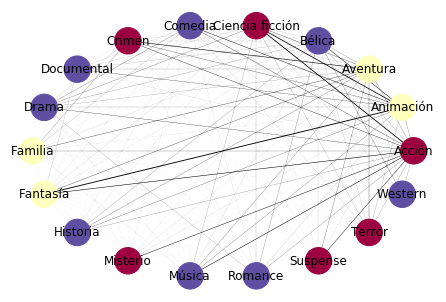

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

nx.draw(
    clusterer.graph_,
    pos=nx.circular_layout(clusterer.graph_),
    labels=names_dict,
    with_labels = True,
    width = [10*x/y_train.shape[0] for x in clusterer.weights_['weight']],
    node_color = [membership_vector[i] for i in range(y_train.shape[1])],
    cmap=plt.cm.Spectral,
    node_size=700,
    font_size=12
)

In [0]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(X_train, y_train)
dev_examples = convert_text_to_examples(X_dev, y_dev)
test_examples = convert_text_to_examples(X_test, y_test)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(dev_input_ids, dev_input_masks, dev_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, dev_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

W0706 09:25:24.832138 140114094110592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [0]:
train_input_ids[0]

array([  101, 31732, 11153, 10183, 10109, 29730, 10104,   140, 46017,
       33167, 10104, 11902, 11968, 10110, 10420, 10225, 10109, 18345,
       14970, 19868, 12440, 10288,   117, 10547, 14949, 10196, 10153,
       11419, 46128, 18738, 10104, 10109, 36716, 11826, 79479,   131,
       10139, 10451, 22238, 10133,   117, 29162, 81873,   193, 13956,
       32837, 85892, 86335,   119,   119,   119,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [0]:
# entre el elif y else
# mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
# masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
#         tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
# input_mask = tf.cast(input_mask, tf.float32)
# pooled = masked_reduce_mean(result, input_mask)

class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="mean",
        bert_path="https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Convolution1D, MaxPooling1D, Input, Bidirectional
from tensorflow.keras.layers import Embedding,CuDNNLSTM, SpatialDropout1D, Reshape, Flatten, BatchNormalization,CuDNNGRU
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.optimizers import Adam, Adagrad

def my_conv1d(kernel_size, layer, filters=10, strides=1, act='relu', reg=None):
  
  c1d = Conv1D(filters = filters, kernel_size = kernel_size, padding='valid', strides=strides, kernel_initializer='he_uniform', kernel_regularizer=reg)(layer)
  c1d = Activation(act)(c1d)
  c1d = BatchNormalization()(c1d)
  
  return c1d

def my_dense(neurons, ant, act='sigmoid', ini='glorot_uniform', reg=None):
  
  dense = Dense(neurons, kernel_initializer=ini, kernel_regularizer=reg)(ant)
  dense = Activation(act)(dense)
  dense = BatchNormalization()(dense)
  
  return dense

In [0]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

from tensorflow.keras import activations 

#https://gist.github.com/iridiumblue/622a9525189d48e9c00659fea269bfa4

class AttentionWithContext(Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False, **kwargs):

        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        input_shape_list = input_shape.as_list()

        self.W = self.add_weight(shape=((input_shape_list[-1], input_shape_list[-1])),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape_list[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape_list[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape.as_list())

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = tf.tensordot(x, self.W,axes=1)

        if self.bias:
            uit += self.b

        uit = activations.tanh(uit)
        # ait = K.dot(uit, self.u)
        ait = tf.tensordot(uit, self.u,axes=1)

        a = activations.exponential(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= tf.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            #TODO use TensorShape here, as done in the else statement.   I'm not sure
            # if this is returning a single tensor, or a list of two so leaving this undone for now.  Suspect this will
            # need to complete if using Sequential rather than Functional API
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return tf.TensorShape([input_shape[0].value,input_shape[-1].value])


In [0]:
def gelu(x):
    return 0.5*x*(1+tf.keras.backend.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.keras.backend.pow(x, 3))))
  
def custom_sigmoid(x):
    return tf.keras.backend.sigmoid(x) + tf.keras.backend.epsilon()

In [0]:
# Build model

#     pooled_output: pooled output of the entire sequence with shape [batch_size, hidden_size].
#     sequence_output: representations of every token in the input sequence with shape [batch_size, max_sequence_length, hidden_size].

# regularizers.l2(0.001)

def build_model(max_seq_length, gru1, gru2, neurons1, neurons2, neurons3, neurons4, drop): 
  
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=0, pooling="mean")(bert_inputs)
    
    x = BatchNormalization()(bert_output)
    x = SpatialDropout1D(drop)(x) 
    
    c = my_conv1d(2 ,x, filters=256, act=gelu)
    m = MaxPooling1D(pool_size=2, padding='valid')(c)
    d = Dropout(drop)(m)
    
    c = my_conv1d(3 ,d, filters=256, act=gelu)
    m = MaxPooling1D(pool_size=2, padding='valid')(c)
    d = Dropout(drop)(m)
    
    
    x = Bidirectional(CuDNNLSTM(gru1, kernel_initializer='glorot_uniform', return_sequences=True))(d)
    x = BatchNormalization()(x)
    x = Bidirectional(CuDNNGRU(gru2, kernel_initializer='glorot_uniform', return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = AttentionWithContext()(x)
    x = BatchNormalization()(x)
    
    x = Dropout(drop)(x)
    x = my_dense(neurons1,x,act=gelu, ini='he_uniform', reg=tf.keras.regularizers.l2(0.0001))
    x = Dropout(drop)(x)
    x = my_dense(neurons2,x,act=gelu, ini='he_uniform', reg=None)
    x = Dropout(drop)(x)
    x = my_dense(neurons3,x,act=gelu, ini='he_uniform', reg=tf.keras.regularizers.l2(0.0001))
    x = Dropout(drop)(x)
    x = my_dense(neurons4,x,act=gelu, ini='he_uniform', reg=None)
    x = Dropout(drop)(x)
    x = Dense(18,activation=custom_sigmoid, kernel_regularizer=None)(x)
    
    model = Model(inputs=bert_inputs, outputs=x)
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="gdrive/My Drive/TFG/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=1)

In [0]:
model = build_model(max_seq_length, 256, 256, 2048, 1024, 512, 256, 0.1)

model.load_weights("gdrive/My Drive/TFG/weights-11-0.92.hdf5")

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 191)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 191)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 191)]        0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, None, 768)    178565115   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [53]:
# Instantiate variables
#initialize_vars(sess)

history = model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    y_train,
    validation_data=([dev_input_ids, dev_input_masks, dev_segment_ids], y_dev),
    epochs=5,
    batch_size=32,
    callbacks = [checkpoint]
)

Train on 40061 samples, validate on 4995 samples
Epoch 1/5
40032/40061 [============================>.] - ETA: 0s - loss: 0.2066 - acc: 0.9200
Epoch 00001: val_loss improved from inf to 0.22197, saving model to gdrive/My Drive/TFG/weights-01-0.91.hdf5
40061/40061 [==============================] - 1264s 32ms/sample - loss: 0.2066 - acc: 0.9199 - val_loss: 0.2220 - val_acc: 0.9148
Epoch 2/5
40032/40061 [============================>.] - ETA: 0s - loss: 0.2029 - acc: 0.9213
Epoch 00002: val_loss improved from 0.22197 to 0.21951, saving model to gdrive/My Drive/TFG/weights-02-0.91.hdf5
40061/40061 [==============================] - 1247s 31ms/sample - loss: 0.2029 - acc: 0.9213 - val_loss: 0.2195 - val_acc: 0.9149
Epoch 3/5
40032/40061 [============================>.] - ETA: 0s - loss: 0.1993 - acc: 0.9227
Epoch 00003: val_loss improved from 0.21951 to 0.21906, saving model to gdrive/My Drive/TFG/weights-03-0.92.hdf5
40061/40061 [==============================] - 1246s 31ms/sample - loss:

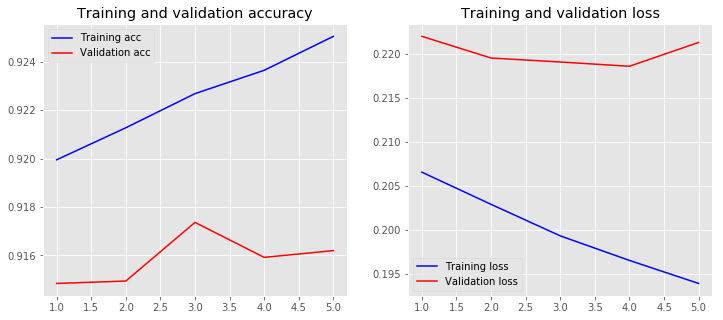

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [0]:
print(model.evaluate([dev_input_ids, dev_input_masks, dev_segment_ids], y_dev))
print(model.evaluate([test_input_ids, test_input_masks, test_segment_ids], y_test))

4995/4995 [==============================] - 131s 26ms/sample - loss: 0.2197 - acc: 0.9167
[0.21968485936746224, 0.9166611]
5005/5005 [==============================] - 129s 26ms/sample - loss: 0.2242 - acc: 0.9147
[0.22417937953036268, 0.91469634]


In [55]:
y_score = model.predict([test_input_ids, test_input_masks, test_segment_ids], verbose = 1)
threshold = 0.5

y_pred = y_score.copy()
y_pred[y_pred >=threshold] = 1
y_pred[y_pred <threshold] = 0


5005/5005 [==============================] - 128s 26ms/sample


In [56]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss

print(f1_score(y_test, y_pred, average='micro'))
print(jaccard_score(y_test, y_pred, average='samples'))
print(hamming_loss(y_test, y_pred))
print(log_loss(y_test, y_pred))

0.5536226790839336
0.4835003092145949
0.08459318459318459
35.0157049032358


In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

for idx,label in enumerate(labels_list):
  print(label + '\n')
  print("Confusion Matrix: \n" + str(confusion_matrix(y_test[:,idx], y_pred[:,idx])))
  print("Accuracy: {:.4f}".format(accuracy_score(y_test[:,idx], y_pred[:,idx])))
  print("F1: {:.4f}".format(f1_score(y_test[:,idx], y_pred[:,idx],pos_label=1)))
  print("Auc: {:.4f}".format(roc_auc_score(y_test[:,idx], y_pred[:,idx])))
  print("-------------------------------------------------------------------")

Acción

Confusion Matrix: 
[[4118  131]
 [ 439  317]]
Accuracy: 0.8861
F1: 0.5266
Auc: 0.6942
-------------------------------------------------------------------
Animación

Confusion Matrix: 
[[4639   35]
 [ 196  135]]
Accuracy: 0.9538
F1: 0.5389
Auc: 0.7002
-------------------------------------------------------------------
Aventura

Confusion Matrix: 
[[4487   55]
 [ 389   74]]
Accuracy: 0.9113
F1: 0.2500
Auc: 0.5739
-------------------------------------------------------------------
Bélica

Confusion Matrix: 
[[4821   36]
 [  75   73]]
Accuracy: 0.9778
F1: 0.5681
Auc: 0.7429
-------------------------------------------------------------------
Ciencia ficción

Confusion Matrix: 
[[4620   26]
 [ 216  143]]
Accuracy: 0.9516
F1: 0.5417
Auc: 0.6964
-------------------------------------------------------------------
Comedia

Confusion Matrix: 
[[3347  291]
 [ 735  632]]
Accuracy: 0.7950
F1: 0.5520
Auc: 0.6912
-------------------------------------------------------------------
Crimen

Confu

In [0]:
model.save('gdrive/My Drive/TFG/my_BertModel2.h5')

In [0]:
pre_save_preds = model.predict([test_input_ids[0:100], 
                                test_input_masks[0:100], 
                                test_segment_ids[0:100]]
                              ) # predictions before we clear and reload model

# Clear and load model
model = None
model = build_model(max_seq_length)
initialize_vars(sess)
model.load_weights('BertModel.h5')

post_save_preds = model.predict([test_input_ids[0:100], 
                                test_input_masks[0:100], 
                                test_segment_ids[0:100]]
                              ) # predictions after we clear and reload model
all(pre_save_preds == post_save_preds) # Are they the same?

